In [33]:
from tensorflow import keras 
import glob, os
import librosa
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
import operator

from sklearn.model_selection import train_test_split
import h5py
from tensorflow.keras.models import load_model

from tensorflow.keras import layers
from tensorflow import keras

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import pandas as pd
import seaborn as sns

We are using all emotions **'angry', 'bore', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad'**, and **'surprised'** not just **'happy', 'sad'**, and **'neutral'**.

In [2]:
#focused_emotion_labels = ['happy', 'sad', 'neutral']

In [34]:
def feature_extractor_audio_file(audio, sample_rate, mfcc, chroma, mel):
    
    if chroma:
        stft = np.abs(librosa.stft(audio))
        result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=audio,
                        sr= sample_rate, n_mfcc = 40).T, axis = 0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(y=audio,
                         sr = sample_rate).T, axis = 0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(audio, 
                      sr=sample_rate).T, axis = 0)
        result = np.hstack((result, mel))
        
    return result

In [35]:
def noise_injection(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretching_audio(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shifting_audio(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def changing_pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [36]:

def audio_augmentation(audio, sample_rate, emotion, x, y):

    noise_audio = noise_injection(audio)
    feature = feature_extractor_audio_file(noise_audio, sample_rate, mfcc = True, chroma = True, mel=True)
    x.append(feature)
    y.append(emotion)


    stretched_audio = stretching_audio(audio)
    feature = feature_extractor_audio_file(stretched_audio, sample_rate, mfcc = True, chroma = True, mel=True)
    x.append(feature)
    y.append(emotion)


    shifted_audio = shifting_audio(audio)
    feature = feature_extractor_audio_file(shifted_audio, sample_rate, mfcc = True, chroma = True, mel=True)
    x.append(feature)
    y.append(emotion)


    pitched_audio = changing_pitch(audio, sample_rate)
    feat = feature_extractor_audio_file(pitched_audio, sample_rate, mfcc = True, chroma = True, mel=True)
    x.append(feature)
    y.append(emotion)

    return x, y



For training process we are using four datasets namely Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS), Berlin Database of Emotional Speech (Emo-DB), Toronto emotional speech set (TESS) and Surrey Audio-Visual Expressed Emotion (SAVEE) database to train our model and we have total 7707 files using these four datasets.

**File identification**:

**REVDESS (songs and speech)** - The filename consists of a 7-part numerical identifier (e.g., 03-02-06-01-02-01-12.wav). 3rd part of numerical is stands for emotion which is fearful. Emotions - (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).


**Emo-DB** - The EMODB database comprises of seven emotions: 1) anger; 2) boredom; 3) anxiety; 4) happiness; 5) sadness; 6) disgust; and 7) neutral. 

Every utterance is named according to the same scheme:

Positions 1-2: number of speaker
Positions 3-5: code for text
Position 6: emotion (sorry, letter stands for german emotion word)
Position 7: if there are more than two versions these are numbered a, b, c ....
Example: 03a01Fa.wav is the audio file from Speaker 03 speaking text a01 with the emotion "Freude" (Happiness).


**TESS** - There are a set of 200 target words were spoken in the carrier phrase 'Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format


**SAVEE** - There are 15 sentences for each of the 7 emotion categories.
The initial letter(s) of the file name represents the emotion class, and the following digits represent the sentence number.
The letters 'a', 'd', 'f', 'h', 'n', 'sa' and 'su' represent 'anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness' and 'surprise' emotion classes respectively. 

E.g., 'd03.wav' is the 3rd disgust sentence. 


In [37]:
def loading_audio_data():
    x = []
    y = []
    REVDESS_datasets = ['C:/Users/AdityaNandgaokar/Aimpower/Main/Emotion_Recognition/dataset_REVDESS_songs/', 
                       'C:/Users/AdityaNandgaokar/Aimpower/Main/Emotion_Recognition/dataset_REVDESS_speechs/']
    
    emotion_labels = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry',
                      '06': 'fear', '07': 'disgust', '08': 'surprised'}
    
    for i in range (len(REVDESS_datasets)):
        print(i)
        for file in glob.glob(REVDESS_datasets[i] + 'Actor_*/*.wav'):
            file_name = os.path.basename(file)
            emotion = emotion_labels[file_name.split('-')[2]]

#             if emotion not in focused_emotion_labels:
#                 continue
            audio, sample_rate = librosa.core.load(file, res_type='kaiser_fast')
            feature = feature_extractor_audio_file(audio, sample_rate, mfcc = True, chroma = True, mel=True)
            
            x.append(feature)
            y.append(emotion)
            
            x, y = audio_augmentation(audio, sample_rate, emotion, x, y)
            

    for file in glob.glob('C:/Users/AdityaNandgaokar/Aimpower/Main/Emotion_Recognition/dataset_Emo-DB/wav/*.wav'):
        file_name = os.path.basename(file)
        file_name = os.path.splitext(file_name)[0].strip()
    
        emotions_dict = {'W' : 'angry', 'L' : 'bore', 'E' : 'disgust', 'A' : 'fear', 
                     'F' : 'happy', 'T' : 'sad', 'N' : 'neutral'}
        
        letter = file_name[5]
        emotion = emotions_dict[letter]
        
#         if emotion not in focused_emotion_labels:
#             continue
        audio, sample_rate = librosa.core.load(file, res_type='kaiser_fast')
        feature = feature_extractor_audio_file(audio, sample_rate, mfcc = True, chroma = True, mel=True)
        x.append(feature)
        y.append(emotion)
        
        x, y = audio_augmentation(audio, sample_rate, emotion, x, y)
        
        
    for file in glob.glob('C:/Users/AdityaNandgaokar/Aimpower/Main/Emotion_Recognition/dataset_TESS/TESS Toronto emotional speech set data/*/*.wav'):

        file_name = os.path.basename(file)
        #file_name = os.path.splitext(file_name)[0].strip()
    
        label = file_name.split('_')[-1]
        label = label.split('.')[0]
        
        if label == 'ps':
            emotion = 'surprised'
            
        else:
            emotion = label
        
        audio, sample_rate = librosa.core.load(file, res_type='kaiser_fast')
        feature = feature_extractor_audio_file(audio, sample_rate, mfcc = True, chroma = True, mel=True)
        
        x.append(feature)
        y.append(emotion)
        
        x, y = audio_augmentation(audio, sample_rate, emotion, x, y)
    
    for file in glob.glob('C:/Users/AdityaNandgaokar/Aimpower/Main/Emotion_Recognition/AudioData/*/*.wav'):
    
        audio, sample_rate = librosa.core.load(file, res_type='kaiser_fast')
        feature = feature_extractor_audio_file(audio, sample_rate, mfcc = True, chroma = True, mel=True)

        SAVEE_letters_dict = {'a' : 'angry', 'd' : 'disgust', 'f' : 'fear', 'h' : 'happy', 'n' : 'neutral', 
                              'sa' : 'sad', 'su' : 'surprised'}

        file_name = os.path.basename(file)

        if file_name[0] == 's':
            emotion = SAVEE_letters_dict[file_name[:2]]

        else:
            emotion = SAVEE_letters_dict[file_name[0]]

        x.append(feature)
        y.append(emotion)
    
        x, y = audio_augmentation(audio, sample_rate, emotion, x, y)    
    
    return np.array(x), y
        

In [54]:
X, y = loading_audio_data()

0
1


In [59]:
X.shape

(38535, 180)

In [39]:
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)
Y = to_categorical(encoded_y)

In [40]:
ss = StandardScaler()
scaled_X = ss.fit_transform(X)

In [ ]:
joblib.dump(ss, 'C:/Users/AdityaNandgaokar/Aimpower/Main/Emotion_Recognition/scaled_train_data.bin', compress=True)

In [53]:
X.shape

(38535, 180, 1)

In [41]:
X = np.expand_dims(scaled_X, -1)
X.shape

(38535, 180, 1)

In [42]:
Y.shape

(38535, 9)

In [43]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state=42)

Our CNN network consisted of two blocks, each built of a 1-dimensional convolution layer, activation function (‘ReLu’), 1-dimensional pooling layer and dropout. The two blocks were followed by two fully connected dense layers and a ‘SoftMax’ activation function, as we are dealing with a multi-class problem:

In [44]:
model = keras.models.Sequential()
model.add(layers.Conv1D(256, 5,padding='same',
                 input_shape=(180,1)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(128, 5,padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=(4)))
model.add(layers.Dropout(0.1))
model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Dense(9))
model.add(layers.Activation('softmax'))

In [16]:
checkpoint_path = 'C:/Users/AdityaNandgaokar/Aimpower/Main/Emotion_Recognition/Models/CNN/checkpoints/CNN.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only = True)


model.compile(optimizer = 'adam', loss ='mean_squared_error', metrics = ['accuracy'])

model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 300, 
          batch_size = 512, shuffle = True, callbacks = [cp_callback])

model.save('C:/Users/AdityaNandgaokar/Aimpower/Main/Emotion_Recognition/Models/CNN/model_CNN.h5')

Epoch 1/300
68/68 [==============================] - 14s 203ms/step - loss: 0.0751 - accuracy: 0.4272 - val_loss: 0.0608 - val_accuracy: 0.5659

Epoch 00001: val_loss improved from inf to 0.06083, saving model to C:/Users/AdityaNandgaokar/Aimpower/Main/Emotion_Recognition/Models/CNN/checkpoints\CNN.ckpt
Epoch 2/300
68/68 [==============================] - 14s 201ms/step - loss: 0.0578 - accuracy: 0.5881 - val_loss: 0.0531 - val_accuracy: 0.6326

Epoch 00002: val_loss improved from 0.06083 to 0.05308, saving model to C:/Users/AdityaNandgaokar/Aimpower/Main/Emotion_Recognition/Models/CNN/checkpoints\CNN.ckpt
Epoch 3/300
68/68 [==============================] - 14s 201ms/step - loss: 0.0520 - accuracy: 0.6359 - val_loss: 0.0480 - val_accuracy: 0.6715

Epoch 00003: val_loss improved from 0.05308 to 0.04802, saving model to C:/Users/AdityaNandgaokar/Aimpower/Main/Emotion_Recognition/Models/CNN/checkpoints\CNN.ckpt
Epoch 4/300
68/68 [==============================] - 15s 222ms/step - loss: 0

68/68 [==============================] - 12s 173ms/step - loss: 0.0216 - accuracy: 0.8674 - val_loss: 0.0163 - val_accuracy: 0.9050

Epoch 00030: val_loss improved from 0.01782 to 0.01631, saving model to C:/Users/AdityaNandgaokar/Aimpower/Main/Emotion_Recognition/Models/CNN/checkpoints\CNN.ckpt
Epoch 31/300
68/68 [==============================] - 12s 178ms/step - loss: 0.0208 - accuracy: 0.8715 - val_loss: 0.0172 - val_accuracy: 0.9011

Epoch 00031: val_loss did not improve from 0.01631
Epoch 32/300
68/68 [==============================] - 12s 172ms/step - loss: 0.0203 - accuracy: 0.8754 - val_loss: 0.0158 - val_accuracy: 0.9040

Epoch 00032: val_loss improved from 0.01631 to 0.01578, saving model to C:/Users/AdityaNandgaokar/Aimpower/Main/Emotion_Recognition/Models/CNN/checkpoints\CNN.ckpt
Epoch 33/300
68/68 [==============================] - 11s 169ms/step - loss: 0.0201 - accuracy: 0.8768 - val_loss: 0.0158 - val_accuracy: 0.9074

Epoch 00033: val_loss did not improve from 0.01578

68/68 [==============================] - 11s 167ms/step - loss: 0.0113 - accuracy: 0.9319 - val_loss: 0.0087 - val_accuracy: 0.9481

Epoch 00097: val_loss did not improve from 0.00798
Epoch 98/300
68/68 [==============================] - 11s 168ms/step - loss: 0.0112 - accuracy: 0.9326 - val_loss: 0.0090 - val_accuracy: 0.9458

Epoch 00098: val_loss did not improve from 0.00798
Epoch 99/300
68/68 [==============================] - 11s 168ms/step - loss: 0.0117 - accuracy: 0.9290 - val_loss: 0.0080 - val_accuracy: 0.9533

Epoch 00099: val_loss did not improve from 0.00798
Epoch 100/300
68/68 [==============================] - 11s 165ms/step - loss: 0.0108 - accuracy: 0.9354 - val_loss: 0.0084 - val_accuracy: 0.9478

Epoch 00100: val_loss did not improve from 0.00798
Epoch 101/300
68/68 [==============================] - 11s 166ms/step - loss: 0.0114 - accuracy: 0.9312 - val_loss: 0.0084 - val_accuracy: 0.9484

Epoch 00101: val_loss did not improve from 0.00798
Epoch 102/300
68/68 [=====

68/68 [==============================] - 11s 164ms/step - loss: 0.0091 - accuracy: 0.9458 - val_loss: 0.0068 - val_accuracy: 0.9580

Epoch 00135: val_loss improved from 0.00692 to 0.00681, saving model to C:/Users/AdityaNandgaokar/Aimpower/Main/Emotion_Recognition/Models/CNN/checkpoints\CNN.ckpt
Epoch 136/300
68/68 [==============================] - 11s 165ms/step - loss: 0.0090 - accuracy: 0.9455 - val_loss: 0.0067 - val_accuracy: 0.9616

Epoch 00136: val_loss improved from 0.00681 to 0.00672, saving model to C:/Users/AdityaNandgaokar/Aimpower/Main/Emotion_Recognition/Models/CNN/checkpoints\CNN.ckpt
Epoch 137/300
68/68 [==============================] - 11s 164ms/step - loss: 0.0091 - accuracy: 0.9450 - val_loss: 0.0073 - val_accuracy: 0.9582

Epoch 00137: val_loss did not improve from 0.00672
Epoch 138/300
68/68 [==============================] - 11s 164ms/step - loss: 0.0094 - accuracy: 0.9429 - val_loss: 0.0073 - val_accuracy: 0.9564

Epoch 00138: val_loss did not improve from 0.00

68/68 [==============================] - 11s 164ms/step - loss: 0.0084 - accuracy: 0.9499 - val_loss: 0.0062 - val_accuracy: 0.9624

Epoch 00172: val_loss did not improve from 0.00588
Epoch 173/300
68/68 [==============================] - 11s 166ms/step - loss: 0.0084 - accuracy: 0.9506 - val_loss: 0.0062 - val_accuracy: 0.9629

Epoch 00173: val_loss did not improve from 0.00588
Epoch 174/300
68/68 [==============================] - 11s 164ms/step - loss: 0.0082 - accuracy: 0.9509 - val_loss: 0.0068 - val_accuracy: 0.9593

Epoch 00174: val_loss did not improve from 0.00588
Epoch 175/300
68/68 [==============================] - 11s 165ms/step - loss: 0.0083 - accuracy: 0.9508 - val_loss: 0.0067 - val_accuracy: 0.9593

Epoch 00175: val_loss did not improve from 0.00588
Epoch 176/300
68/68 [==============================] - 11s 165ms/step - loss: 0.0080 - accuracy: 0.9531 - val_loss: 0.0066 - val_accuracy: 0.9608

Epoch 00176: val_loss did not improve from 0.00588
Epoch 177/300
68/68 [===

68/68 [==============================] - 11s 164ms/step - loss: 0.0075 - accuracy: 0.9558 - val_loss: 0.0066 - val_accuracy: 0.9613

Epoch 00213: val_loss did not improve from 0.00578
Epoch 214/300
68/68 [==============================] - 11s 165ms/step - loss: 0.0080 - accuracy: 0.9527 - val_loss: 0.0065 - val_accuracy: 0.9608

Epoch 00214: val_loss did not improve from 0.00578
Epoch 215/300
68/68 [==============================] - 11s 165ms/step - loss: 0.0080 - accuracy: 0.9516 - val_loss: 0.0065 - val_accuracy: 0.9616

Epoch 00215: val_loss did not improve from 0.00578
Epoch 216/300
68/68 [==============================] - 11s 165ms/step - loss: 0.0072 - accuracy: 0.9576 - val_loss: 0.0065 - val_accuracy: 0.9613

Epoch 00216: val_loss did not improve from 0.00578
Epoch 217/300
68/68 [==============================] - 11s 165ms/step - loss: 0.0077 - accuracy: 0.9540 - val_loss: 0.0065 - val_accuracy: 0.9621

Epoch 00217: val_loss did not improve from 0.00578
Epoch 218/300
68/68 [===

68/68 [==============================] - 12s 172ms/step - loss: 0.0067 - accuracy: 0.9614 - val_loss: 0.0060 - val_accuracy: 0.9634

Epoch 00294: val_loss did not improve from 0.00529
Epoch 295/300
68/68 [==============================] - 12s 171ms/step - loss: 0.0065 - accuracy: 0.9619 - val_loss: 0.0054 - val_accuracy: 0.9696

Epoch 00295: val_loss did not improve from 0.00529
Epoch 296/300
68/68 [==============================] - 12s 171ms/step - loss: 0.0067 - accuracy: 0.9598 - val_loss: 0.0056 - val_accuracy: 0.9678

Epoch 00296: val_loss did not improve from 0.00529
Epoch 297/300
68/68 [==============================] - 12s 172ms/step - loss: 0.0068 - accuracy: 0.9593 - val_loss: 0.0058 - val_accuracy: 0.9660

Epoch 00297: val_loss did not improve from 0.00529
Epoch 298/300
68/68 [==============================] - 12s 173ms/step - loss: 0.0066 - accuracy: 0.9613 - val_loss: 0.0058 - val_accuracy: 0.9634

Epoch 00298: val_loss did not improve from 0.00529
Epoch 299/300
68/68 [===

In [17]:
pred = model.predict(x_test)

**Actual labels of the audio files**

In [18]:
y_actual = []
for i in range(len(x_test)):
    actual_label = np.argmax(y_test[i], axis=None, out=None)
    emotion = label_encoder.inverse_transform([actual_label])
    print(emotion[0])
    y_actual.append(emotion[0])

sad
disgust
calm
happy
angry
disgust
neutral
angry
neutral
sad
surprised
sad
calm
angry
fear
disgust
disgust
neutral
fear
happy
sad
sad
fear
sad
disgust
fear
sad
sad
fear
happy
surprised
surprised
angry
sad
sad
angry
happy
calm
sad
angry
sad
sad
sad
happy
sad
happy
fear
sad
disgust
neutral
disgust
angry
happy
calm
neutral
neutral
sad
happy
fear
disgust
calm
calm
calm
sad
calm
disgust
fear
happy
calm
fear
calm
fear
fear
surprised
neutral
disgust
happy
disgust
sad
happy
fear
fear
calm
angry
fear
surprised
happy
happy
happy
disgust
neutral
disgust
sad
sad
angry
fear
neutral
happy
happy
sad
happy
fear
sad
disgust
sad
bore
sad
disgust
surprised
fear
calm
fear
disgust
neutral
calm
surprised
angry
happy
neutral
neutral
happy
disgust
happy
neutral
sad
sad
sad
fear
neutral
sad
happy
surprised
neutral
happy
fear
fear
angry
calm
sad
fear
happy
angry
angry
disgust
angry
happy
sad
disgust
happy
surprised
happy
disgust
surprised
neutral
happy
happy
fear
fear
disgust
sad
angry
disgust
bore
angry
fear

sad
sad
neutral
happy
sad
sad
happy
fear
surprised
neutral
happy
fear
calm
surprised
fear
surprised
sad
calm
happy
surprised
neutral
fear
sad
happy
fear
happy
angry
happy
sad
surprised
happy
disgust
angry
neutral
sad
angry
happy
neutral
sad
fear
angry
surprised
happy
fear
fear
calm
fear
fear
sad
surprised
disgust
fear
surprised
happy
angry
calm
sad
surprised
calm
surprised
surprised
fear
angry
disgust
bore
calm
fear
sad
disgust
calm
surprised
fear
disgust
angry
neutral
sad
angry
surprised
disgust
disgust
neutral
sad
sad
sad
disgust
sad
happy
happy
disgust
fear
disgust
sad
neutral
calm
neutral
surprised
disgust
disgust
angry
sad
disgust
disgust
neutral
sad
surprised
sad
angry
surprised
happy
happy
disgust
fear
happy
sad
angry
disgust
disgust
happy
happy
calm
angry
disgust
angry
disgust
calm
fear
angry
angry
calm
angry
happy
bore
angry
sad
fear
happy
disgust
neutral
surprised
sad
surprised
sad
disgust
neutral
surprised
neutral
surprised
disgust
neutral
happy
neutral
neutral
angry
neutral

angry
disgust
neutral
sad
happy
disgust
fear
disgust
happy
surprised
disgust
happy
surprised
disgust
surprised
disgust
fear
surprised
angry
sad
disgust
disgust
fear
fear
happy
disgust
happy
happy
fear
surprised
angry
sad
disgust
happy
angry
happy
surprised
angry
sad
neutral
surprised
neutral
surprised
neutral
angry
sad
angry
disgust
happy
neutral
disgust
neutral
fear
bore
surprised
fear
fear
surprised
surprised
disgust
angry
neutral
happy
happy
surprised
surprised
angry
surprised
angry
disgust
sad
calm
happy
sad
happy
happy
sad
neutral
calm
angry
disgust
happy
surprised
surprised
surprised
calm
disgust
happy
angry
fear
happy
surprised
angry
fear
happy
fear
sad
happy
sad
angry
fear
neutral
surprised
surprised
angry
angry
fear
surprised
surprised
angry
sad
sad
happy
neutral
angry
fear
neutral
neutral
sad
fear
angry
fear
calm
neutral
fear
sad
angry
surprised
happy
sad
neutral
sad
fear
angry
disgust
happy
neutral
sad
fear
angry
happy
sad
happy
angry
neutral
sad
disgust
angry
angry
sad
calm

**Predicted labels by the model**

In [19]:
y_pred = []
for i in range(len(x_test)):
    predicted_label = np.argmax(pred[i], axis=None, out=None)
    emotion = label_encoder.inverse_transform([predicted_label])
    print(emotion[0])
    y_pred.append(emotion[0])

fear
disgust
calm
happy
angry
disgust
neutral
angry
neutral
sad
surprised
sad
calm
angry
fear
disgust
disgust
neutral
fear
happy
sad
sad
fear
sad
disgust
fear
sad
sad
fear
happy
surprised
surprised
angry
sad
sad
angry
happy
calm
sad
angry
sad
sad
sad
happy
sad
happy
fear
sad
disgust
neutral
disgust
angry
happy
calm
neutral
neutral
sad
happy
fear
disgust
calm
calm
calm
sad
calm
sad
fear
happy
calm
fear
calm
fear
fear
surprised
neutral
disgust
happy
disgust
sad
happy
fear
fear
calm
angry
fear
surprised
happy
happy
happy
disgust
neutral
disgust
sad
sad
angry
fear
neutral
happy
happy
sad
happy
fear
sad
disgust
sad
bore
sad
disgust
surprised
fear
calm
fear
disgust
neutral
calm
surprised
angry
happy
neutral
neutral
happy
disgust
happy
neutral
sad
sad
sad
fear
neutral
sad
happy
sad
neutral
happy
fear
fear
angry
calm
sad
fear
happy
angry
angry
disgust
angry
happy
sad
disgust
fear
surprised
happy
disgust
surprised
neutral
happy
happy
fear
fear
disgust
sad
angry
disgust
bore
angry
fear
angry
ang

calm
fear
sad
disgust
calm
surprised
fear
disgust
angry
neutral
sad
angry
surprised
disgust
disgust
neutral
sad
sad
sad
disgust
sad
happy
happy
disgust
fear
disgust
sad
neutral
calm
neutral
surprised
disgust
happy
angry
sad
disgust
disgust
neutral
sad
surprised
sad
angry
surprised
happy
happy
disgust
fear
happy
sad
angry
disgust
disgust
happy
happy
calm
angry
disgust
angry
disgust
calm
fear
angry
disgust
calm
angry
happy
bore
sad
sad
fear
happy
disgust
neutral
surprised
sad
surprised
sad
disgust
neutral
surprised
neutral
surprised
disgust
neutral
happy
neutral
neutral
angry
neutral
disgust
happy
disgust
disgust
calm
sad
angry
fear
happy
neutral
happy
happy
disgust
angry
happy
fear
disgust
neutral
surprised
neutral
surprised
happy
neutral
disgust
disgust
happy
fear
sad
calm
disgust
angry
fear
sad
angry
fear
calm
angry
surprised
angry
angry
disgust
angry
disgust
fear
surprised
sad
fear
angry
neutral
happy
angry
surprised
calm
angry
surprised
neutral
sad
neutral
disgust
surprised
neutral


sad
disgust
happy
angry
happy
surprised
angry
sad
neutral
surprised
neutral
surprised
neutral
angry
sad
angry
disgust
happy
neutral
disgust
calm
fear
bore
surprised
fear
fear
surprised
disgust
disgust
angry
neutral
happy
happy
surprised
surprised
angry
surprised
angry
disgust
sad
calm
happy
sad
happy
happy
sad
neutral
calm
sad
disgust
happy
surprised
surprised
surprised
calm
disgust
happy
angry
fear
happy
surprised
happy
fear
happy
fear
sad
happy
sad
angry
sad
neutral
surprised
surprised
angry
angry
fear
surprised
surprised
angry
sad
sad
happy
neutral
angry
fear
neutral
neutral
sad
fear
angry
fear
calm
neutral
fear
sad
angry
surprised
happy
sad
neutral
sad
fear
angry
disgust
happy
neutral
sad
fear
angry
happy
sad
happy
angry
neutral
sad
disgust
angry
angry
sad
calm
fear
neutral
angry
happy
disgust
fear
surprised
fear
surprised
sad
sad
fear
angry
sad
angry
neutral
sad
surprised
surprised
angry
angry
surprised
surprised
angry
neutral
happy
sad
sad
angry
happy
sad
happy
fear
neutral
surpr

**Checking confidence for each emotion**

In [20]:
for i in range(len(x_test)):
    actual_label = np.argmax(pred[i], axis=None, out=None)
    emotion = label_encoder.inverse_transform([actual_label])
    print('Predicted Emotion is {}'. format(emotion[0]))
    all_pred = pred[i] *100
    prediction_dict = {}
    for j in range(len(all_pred)):
        value = ("%.17f" % all_pred[j]).rstrip('0').rstrip('.')
        key_emotion = label_encoder.inverse_transform([j])

        prediction_dict[key_emotion[0]] = value

    sorted_pred_dict = dict(sorted(prediction_dict.items(),
                                   key=operator.itemgetter(1),
                                   reverse=True))
    print('Confidence For All Emotions\n')
    for k in sorted_pred_dict:
        print('{} = {}'.format(k, sorted_pred_dict[k]))  
    print('\n')

Predicted Emotion is fear
Confidence For All Emotions

fear = 94.03066253662109375
sad = 4.48379278182983398
happy = 1.04493105411529541
surprised = 0.19819881021976471
disgust = 0.15744820237159729
angry = 0.08321256935596466
calm = 0.00119863357394934
neutral = 0.00047213156358339
bore = 0.00007539141370216


Predicted Emotion is disgust
Confidence For All Emotions

disgust = 100
neutral = 0.00000000229778929
surprised = 0.00000000105852793
fear = 0.00000000008844159
happy = 0.00000000001747057
sad = 0.00000000001007475
bore = 0.000000000000316
angry = 0.0000000000001321
calm = 0.00000000000000013


Predicted Emotion is calm
Confidence For All Emotions

calm = 99.987884521484375
sad = 0.00735859479755163
happy = 0.00274355849251151
neutral = 0.00199779053218663
bore = 0.00000082017174918
fear = 0.00000072620099445
angry = 0.00000049164879101
disgust = 0.00000005511024526
surprised = 0.00000000593180083


Predicted Emotion is happy
Confidence For All Emotions

happy = 100
fear = 0.000

calm = 0.00000011759448881
fear = 0.00000007988120387
surprised = 0.00000000731604688
happy = 0.00000000127160749
bore = 0.0000000000099145


Predicted Emotion is angry
Confidence For All Emotions

angry = 100
happy = 0.00000226318297791
disgust = 0.00000000000104938
fear = 0.00000000000023926
neutral = 0.00000000000000001
bore = 0
calm = 0
sad = 0
surprised = 0


Predicted Emotion is disgust
Confidence For All Emotions

disgust = 100
neutral = 0.00000000284418555
surprised = 0.00000000000117841
happy = 0.00000000000000794
fear = 0.0000000000000064
sad = 0.00000000000000178
angry = 0.00000000000000018
bore = 0
calm = 0


Predicted Emotion is bore
Confidence For All Emotions

bore = 100
neutral = 0.00000077084240502
happy = 0.00000000266499911
fear = 0.00000000000012761
angry = 0.00000000000000029
sad = 0.00000000000000021
calm = 0
disgust = 0
surprised = 0


Predicted Emotion is angry
Confidence For All Emotions

angry = 99.06877899169921875
sad = 0.69044733047485352
calm = 0.229354411

Predicted Emotion is angry
Confidence For All Emotions

angry = 99.9998321533203125
fear = 0.00016706810856704
bore = 0.00000017799975183
disgust = 0.00000002833991175
happy = 0.00000002204779115
surprised = 0.00000000095653585
neutral = 0.0000000004072335
sad = 0.00000000029148667
calm = 0.00000000000000002


Predicted Emotion is neutral
Confidence For All Emotions

neutral = 100
bore = 0.00000000000000586
fear = 0.00000000000000005
disgust = 0.00000000000000001
angry = 0
calm = 0
happy = 0
sad = 0
surprised = 0


Predicted Emotion is calm
Confidence For All Emotions

calm = 99.61609649658203125
neutral = 0.38390594720840454
disgust = 0.00000207977609534
angry = 0.00000124751034036
sad = 0.00000041182806854
bore = 0.00000014881238997
happy = 0.00000010562870756
fear = 0.00000000745955475
surprised = 0.00000000010702624


Predicted Emotion is fear
Confidence For All Emotions

fear = 100
happy = 0.00000000000005795
angry = 0
bore = 0
calm = 0
disgust = 0
neutral = 0
sad = 0
surprised = 

Confidence For All Emotions

disgust = 96.12368011474609375
angry = 1.91518998146057129
fear = 1.75094211101531982
happy = 0.11748454719781876
surprised = 0.03425677865743637
sad = 0.02705061994493008
neutral = 0.02095443569123745
calm = 0.00821192562580109
bore = 0.00221479078754783


Predicted Emotion is neutral
Confidence For All Emotions

neutral = 99.99855804443359375
sad = 0.00114708440378308
angry = 0.0002763124066405
calm = 0.00001075717318599
fear = 0.00000658529233988
happy = 0.00000052796633554
bore = 0.00000039807412122
disgust = 0.00000000534194378
surprised = 0.00000000000378379


Predicted Emotion is sad
Confidence For All Emotions

sad = 100
fear = 0.00000000456664129
neutral = 0.00000000017859492
angry = 0.0000000000008352
calm = 0.00000000000000128
bore = 0.00000000000000001
disgust = 0
happy = 0
surprised = 0


Predicted Emotion is fear
Confidence For All Emotions

fear = 97.5125579833984375
sad = 2.24670529365539551
happy = 0.17817975580692291
angry = 0.039187345653

Confidence For All Emotions

happy = 99.99985504150390625
angry = 0.00014643842587247
fear = 0.00000017727811041
disgust = 0.00000000001918245
neutral = 0.00000000000179374
calm = 0.00000000000054659
bore = 0.00000000000000337
sad = 0.00000000000000001
surprised = 0


Predicted Emotion is disgust
Confidence For All Emotions

disgust = 100
angry = 0.00000022468162797
fear = 0.00000001442590669
happy = 0.00000001362286817
sad = 0.00000000115259458
neutral = 0.00000000009997651
bore = 0.00000000000492759
surprised = 0.00000000000105862
calm = 0.00000000000000001


Predicted Emotion is disgust
Confidence For All Emotions

disgust = 99.925811767578125
fear = 0.03670048713684082
happy = 0.02273850701749325
surprised = 0.00902436766773462
sad = 0.00427235336974263
calm = 0.00124273763503879
neutral = 0.00017394075985067
angry = 0.00002941850107163
bore = 0.00000022362472407


Predicted Emotion is disgust
Confidence For All Emotions

disgust = 99.92708587646484375
fear = 0.06807396560907364
su

Confidence For All Emotions

happy = 100
angry = 0
bore = 0
calm = 0
disgust = 0
fear = 0
neutral = 0
sad = 0
surprised = 0


Predicted Emotion is surprised
Confidence For All Emotions

surprised = 99.63824462890625
fear = 0.32041981816291809
happy = 0.02726641483604908
disgust = 0.01377836335450411
angry = 0.00022730050841346
sad = 0.0000470766754006
neutral = 0.00001365583375446
calm = 0.00000146012837376
bore = 0.00000000182410143


Predicted Emotion is sad
Confidence For All Emotions

sad = 99.638641357421875
neutral = 0.18224434554576874
disgust = 0.10299143940210342
fear = 0.03983447700738907
calm = 0.02853645384311676
surprised = 0.00319407694041729
bore = 0.00164531334303319
happy = 0.00149130693171173
angry = 0.00142031151335686


Predicted Emotion is happy
Confidence For All Emotions

happy = 99.97122955322265625
fear = 0.02664968743920326
angry = 0.00212318636476994
disgust = 0.00000002760501516
surprised = 0.00000000048374205
bore = 0.00000000000001807
neutral = 0.000000000

angry = 0
bore = 0
disgust = 0
surprised = 0


Predicted Emotion is angry
Confidence For All Emotions

angry = 100
fear = 0.0000000000000002
bore = 0
calm = 0
disgust = 0
happy = 0
neutral = 0
sad = 0
surprised = 0


Predicted Emotion is disgust
Confidence For All Emotions

disgust = 99.96783447265625
neutral = 0.01814331486821175
calm = 0.00946742761880159
happy = 0.00342285679653287
sad = 0.00112423382233828
fear = 0.00001631053783058
angry = 0.00000026124413921
bore = 0.0000001091248194
surprised = 0.00000004020032662


Predicted Emotion is calm
Confidence For All Emotions

calm = 99.96393585205078125
neutral = 0.02478102594614029
sad = 0.00845965556800365
fear = 0.00215755240060389
disgust = 0.0004790065868292
happy = 0.00015324607375078
angry = 0.00002500285336282
bore = 0.00000138447728659
surprised = 0.00000000315266035


Predicted Emotion is disgust
Confidence For All Emotions

disgust = 91.7502593994140625
surprised = 4.134857177734375
sad = 2.76739597320556641
fear = 0.589071

neutral = 100
bore = 0.00000000000000586
calm = 0.00000000000000027
angry = 0
disgust = 0
fear = 0
happy = 0
sad = 0
surprised = 0


Predicted Emotion is happy
Confidence For All Emotions

happy = 100
angry = 0.00000057823024235
fear = 0.0000000000490309
disgust = 0.00000000000000881
bore = 0
calm = 0
neutral = 0
sad = 0
surprised = 0


Predicted Emotion is surprised
Confidence For All Emotions

surprised = 99.90453338623046875
fear = 0.05338670313358307
happy = 0.02188770286738873
disgust = 0.01048275269567966
angry = 0.00897633191198111
neutral = 0.00040484452620149
sad = 0.0003283527912572
bore = 0.00000059425622112
calm = 0.00000000739609618


Predicted Emotion is sad
Confidence For All Emotions

sad = 99.8787078857421875
fear = 0.07151121646165848
disgust = 0.02904608845710754
neutral = 0.00973579287528992
happy = 0.00482528796419501
surprised = 0.00343055836856365
angry = 0.00167851068545133
calm = 0.00103436969220638
bore = 0.00001551265995658


Predicted Emotion is sad
Confiden

Confidence For All Emotions

surprised = 99.73038482666015625
happy = 0.16352909803390503
angry = 0.08174233138561249
fear = 0.01148610096424818
disgust = 0.00964985974133015
sad = 0.00319486600346863
neutral = 0.00001043257725541
calm = 0.00000277427739093
bore = 0.00000000189447902


Predicted Emotion is surprised
Confidence For All Emotions

surprised = 99.995269775390625
happy = 0.00213321670889854
calm = 0.00136229721829295
angry = 0.00090970908058807
sad = 0.00027163879713044
fear = 0.00002930751543317
neutral = 0.00001851865454228
disgust = 0.00000526915027876
bore = 0.00000000042724788


Predicted Emotion is happy
Confidence For All Emotions

happy = 100
angry = 0
bore = 0
calm = 0
disgust = 0
fear = 0
neutral = 0
sad = 0
surprised = 0


Predicted Emotion is calm
Confidence For All Emotions

calm = 98.38291168212890625
neutral = 1.04866170883178711
sad = 0.36702066659927368
happy = 0.09159089624881744
fear = 0.07506196200847626
angry = 0.03267648071050644
disgust = 0.0018259610

Predicted Emotion is calm
Confidence For All Emotions

calm = 99.8229217529296875
sad = 0.15511998534202576
neutral = 0.01692822389304638
fear = 0.00421895552426577
surprised = 0.00051885400898755
angry = 0.00020449110888876
happy = 0.00007743551395833
disgust = 0.00000126794259359
bore = 0.00000003065663989


Predicted Emotion is neutral
Confidence For All Emotions

neutral = 99.26258087158203125
disgust = 0.45067551732063293
sad = 0.22712664306163788
bore = 0.05958486720919609
fear = 0.00002822062924679
surprised = 0.00000593220602241
calm = 0.00000058575466255
angry = 0.00000007039839289
happy = 0.00000000356555407


Predicted Emotion is disgust
Confidence For All Emotions

disgust = 100
surprised = 0.00000001406592354
happy = 0.00000000064599726
bore = 0.00000000027746075
angry = 0.00000000006762246
fear = 0.00000000000015879
neutral = 0.00000000000000055
calm = 0
sad = 0


Predicted Emotion is neutral
Confidence For All Emotions

neutral = 100
bore = 0.0000000002502436
angry = 0
c

Confidence For All Emotions

neutral = 95.39575958251953125
sad = 2.76451826095581055
calm = 1.3293379545211792
disgust = 0.23038718104362488
happy = 0.10471504926681519
angry = 0.07810237258672714
surprised = 0.06941598653793335
fear = 0.02563726156949997
bore = 0.00213167304173112


Predicted Emotion is fear
Confidence For All Emotions

fear = 81.2494964599609375
neutral = 4.11367654800415039
sad = 12.77865886688232422
surprised = 1.33420312404632568
happy = 0.46384343504905701
bore = 0.03088372759521008
calm = 0.01823054254055023
angry = 0.00833635963499546
disgust = 0.00265644048340619


Predicted Emotion is sad
Confidence For All Emotions

sad = 99.9999847412109375
fear = 0.00001271734072361
disgust = 0.00000000493993912
calm = 0.00000000001845352
neutral = 0.00000000000000046
happy = 0.00000000000000016
surprised = 0.00000000000000004
angry = 0.00000000000000002
bore = 0


Predicted Emotion is sad
Confidence For All Emotions

sad = 99.99687957763671875
calm = 0.0025072970893234
n

calm = 0.00000000000000001
bore = 0
surprised = 0


Predicted Emotion is happy
Confidence For All Emotions

happy = 87.068084716796875
angry = 5.93080949783325195
sad = 5.56214141845703125
calm = 1.14617371559143066
fear = 0.17962527275085449
disgust = 0.11171779036521912
surprised = 0.0007351313252002
neutral = 0.00068999559152871
bore = 0.00003209926580894


Predicted Emotion is disgust
Confidence For All Emotions

disgust = 100
fear = 0.00000000250474841
bore = 0.00000000000487308
happy = 0.00000000000051843
neutral = 0.00000000000029196
surprised = 0.00000000000000103
angry = 0.00000000000000004
calm = 0
sad = 0


Predicted Emotion is angry
Confidence For All Emotions

angry = 99.96099853515625
fear = 0.03894152119755745
happy = 0.00005450220487546
disgust = 0.00000549818923901
surprised = 0.00000074081930279
sad = 0.00000014493302558
bore = 0.00000014136438153
neutral = 0.00000000017595067
calm = 0.00000000000001959


Predicted Emotion is happy
Confidence For All Emotions

happy =

Confidence For All Emotions

happy = 96.52425384521484375
fear = 3.16216731071472168
surprised = 0.25353479385375977
angry = 0.06000197678804398
sad = 0.00002683286402316
calm = 0.00001078355853679
disgust = 0.00000214898773265
neutral = 0.00000072907437243
bore = 0.00000000020347482


Predicted Emotion is fear
Confidence For All Emotions

fear = 99.9998931884765625
happy = 0.00005192335447646
angry = 0.00004898632323602
disgust = 0.00000278718630398
surprised = 0.00000025519585733
sad = 0.00000014494186473
neutral = 0.00000001276477146
calm = 0.00000000014272257
bore = 0.00000000000001794


Predicted Emotion is neutral
Confidence For All Emotions

neutral = 100
bore = 0.00000000000000024
angry = 0
calm = 0
disgust = 0
fear = 0
happy = 0
sad = 0
surprised = 0


Predicted Emotion is disgust
Confidence For All Emotions

disgust = 98.2786407470703125
happy = 0.51165831089019775
surprised = 0.47158944606781006
fear = 0.38257458806037903
angry = 0.30431890487670898
sad = 0.0375610776245594



fear = 99.99877166748046875
angry = 0.00122289615683258
happy = 0.00000003243870239
sad = 0.00000000903826081
surprised = 0.00000000003957402
disgust = 0.00000000000000095
neutral = 0.00000000000000017
bore = 0
calm = 0


Predicted Emotion is disgust
Confidence For All Emotions

surprised = 8.65917587280273438
sad = 6.34909200668334961
disgust = 44.27251815795898438
angry = 3.29887485504150391
happy = 20.39423942565917969
fear = 15.46300506591796875
calm = 1.12739396095275879
neutral = 0.29975244402885437
bore = 0.13593752682209015


Predicted Emotion is angry
Confidence For All Emotions

angry = 100
fear = 0.00000000695724323
happy = 0.00000000000000121
bore = 0
calm = 0
disgust = 0
neutral = 0
sad = 0
surprised = 0


Predicted Emotion is angry
Confidence For All Emotions

angry = 99.4480133056640625
disgust = 0.49250856041908264
happy = 0.02654342912137508
surprised = 0.02198545075953007
neutral = 0.00644561927765608
fear = 0.00279563246294856
sad = 0.00169946381356567
bore = 0.0000


bore = 100
neutral = 0.00000000414676737
disgust = 0.0000000000164592
angry = 0
calm = 0
fear = 0
happy = 0
sad = 0
surprised = 0


Predicted Emotion is surprised
Confidence For All Emotions

surprised = 98.87432861328125
fear = 1.01219940185546875
happy = 0.06529465317726135
angry = 0.04509356617927551
neutral = 0.00223928596824408
sad = 0.00083284784341231
disgust = 0.0000039995361476
bore = 0.00000000740270956
calm = 0.00000000235185715


Predicted Emotion is fear
Confidence For All Emotions

fear = 99.9189453125
sad = 0.0810137614607811
neutral = 0.00001931574843184
happy = 0.00000818154057924
disgust = 0.00000743678538129
surprised = 0.00000457341093352
calm = 0.00000076887164369
angry = 0.00000000033933456
bore = 0.00000000006428243


Predicted Emotion is neutral
Confidence For All Emotions

neutral = 100
bore = 0.00000000000000054
angry = 0
calm = 0
disgust = 0
fear = 0
happy = 0
sad = 0
surprised = 0


Predicted Emotion is neutral
Confidence For All Emotions

neutral = 100
ang

angry = 0
bore = 0
calm = 0
disgust = 0
happy = 0
neutral = 0
sad = 0
surprised = 0


Predicted Emotion is surprised
Confidence For All Emotions

surprised = 99.9999847412109375
disgust = 0.00000550092136109
sad = 0.00000403446756536
fear = 0.00000030364185477
happy = 0.00000007803271274
angry = 0.00000001385939807
calm = 0.00000000001510666
neutral = 0.00000000000203111
bore = 0.00000000000019637


Predicted Emotion is happy
Confidence For All Emotions

happy = 100
angry = 0.00000000000000003
bore = 0
calm = 0
disgust = 0
fear = 0
neutral = 0
sad = 0
surprised = 0


Predicted Emotion is disgust
Confidence For All Emotions

disgust = 100
fear = 0.00000504768922838
happy = 0.00000029987663197
surprised = 0.00000016457572372
angry = 0.00000000112822507
bore = 0.00000000033500153
neutral = 0.00000000009173222
sad = 0.00000000002320965
calm = 0.00000000000022361


Predicted Emotion is surprised
Confidence For All Emotions

surprised = 93.90918731689453125
sad = 3.46850085258483887
fear = 1

Confidence For All Emotions

sad = 100
fear = 0.00000000062121031
angry = 0.00000000014493653
neutral = 0.00000000000256241
calm = 0.00000000000094073
surprised = 0.00000000000008068
disgust = 0.00000000000000003
bore = 0.00000000000000002
happy = 0


Predicted Emotion is fear
Confidence For All Emotions

fear = 100
sad = 0.00000004715938218
neutral = 0.0000000019905404
bore = 0.00000000000000326
surprised = 0.00000000000000064
angry = 0
calm = 0
disgust = 0
happy = 0


Predicted Emotion is fear
Confidence For All Emotions

fear = 99.9996337890625
sad = 0.00021371695038397
neutral = 0.00014898634981364
happy = 0.00000972531597654
angry = 0.00000083509468141
calm = 0.00000000115652998
bore = 0.00000000047529758
surprised = 0.00000000000147553
disgust = 0.0000000000001888


Predicted Emotion is happy
Confidence For All Emotions

happy = 99.77729034423828125
angry = 0.15317247807979584
fear = 0.06807341426610947
disgust = 0.00116021884605289
surprised = 0.000226510950597
sad = 0.000078272

fear = 13.03313255310058594
angry = 1.16000747680664062
happy = 0.89268910884857178
surprised = 0.7633357048034668
neutral = 0.71277713775634766
sad = 0.62966704368591309
disgust = 0.00006721996032866
bore = 0.00000000707291781


Predicted Emotion is disgust
Confidence For All Emotions

disgust = 99.9853363037109375
angry = 0.01380872819572687
happy = 0.00075510499300435
fear = 0.00004031016578665
bore = 0.00002617939571792
neutral = 0.00001120000706578
surprised = 0.00000641586757411
sad = 0.00000019574632404
calm = 0.00000001502703206


Predicted Emotion is surprised
Confidence For All Emotions

surprised = 99.9539642333984375
disgust = 0.01840158924460411
happy = 0.01432632002979517
angry = 0.01290478929877281
fear = 0.00030935966060497
sad = 0.00009293446782976
neutral = 0.00000039222339865
calm = 0.00000000411472101
bore = 0.00000000023877389


Predicted Emotion is fear
Confidence For All Emotions

fear = 100
angry = 0.00000000000015462
bore = 0
calm = 0
disgust = 0
happy = 0
neut


disgust = 100
angry = 0
bore = 0
calm = 0
fear = 0
happy = 0
neutral = 0
sad = 0
surprised = 0


Predicted Emotion is angry
Confidence For All Emotions

angry = 100
bore = 0
calm = 0
disgust = 0
fear = 0
happy = 0
neutral = 0
sad = 0
surprised = 0


Predicted Emotion is angry
Confidence For All Emotions

angry = 99.53728485107421875
disgust = 0.45778262615203857
surprised = 0.00491355778649449
happy = 0.00002403551479802
fear = 0.00000050086003966
sad = 0.00000000016744588
neutral = 0.00000000000013049
bore = 0.00000000000004342
calm = 0.00000000000000962


Predicted Emotion is disgust
Confidence For All Emotions

disgust = 100
happy = 0.00000002487500694
surprised = 0.00000000096119557
angry = 0.00000000013286509
bore = 0.00000000000063006
neutral = 0.00000000000023457
sad = 0.0000000000001304
fear = 0.0000000000000932
calm = 0.00000000000000001


Predicted Emotion is fear
Confidence For All Emotions

fear = 99.9779052734375
angry = 0.02149298787117004
happy = 0.00060435489285737
dis


surprised = 100
fear = 0.00000000000000014
angry = 0
bore = 0
calm = 0
disgust = 0
happy = 0
neutral = 0
sad = 0


Predicted Emotion is sad
Confidence For All Emotions

sad = 99.99167633056640625
fear = 0.00781414099037647
calm = 0.00044261338189244
neutral = 0.0000603236585448
bore = 0.0000023815748591
disgust = 0.00000131243643864
surprised = 0.00000027389850743
happy = 0.00000019769640858
angry = 0.00000001000932581


Predicted Emotion is sad
Confidence For All Emotions

sad = 100
calm = 0.00000000000019066
fear = 0.00000000000002378
disgust = 0.00000000000000025
neutral = 0.00000000000000001
angry = 0
bore = 0
happy = 0
surprised = 0


Predicted Emotion is happy
Confidence For All Emotions

happy = 99.991546630859375
fear = 0.00387517246417701
calm = 0.00381669448688626
angry = 0.00040926443762146
surprised = 0.00022661668481305
neutral = 0.00007116067718016
disgust = 0.000042829906306
sad = 0.00000140231213663
bore = 0.00000002929408716


Predicted Emotion is disgust
Confidence F


fear = 99.9999542236328125
angry = 0.00005004388367524
surprised = 0.00000005624215405
happy = 0.00000000986980186
neutral = 0.00000000721375759
bore = 0.00000000000258423
sad = 0.00000000000141384
disgust = 0.00000000000000991
calm = 0


Predicted Emotion is disgust
Confidence For All Emotions

disgust = 100
angry = 0.0000000000723616
bore = 0.00000000000231312
fear = 0.00000000000116538
happy = 0.00000000000061573
neutral = 0.00000000000023861
sad = 0.00000000000014396
surprised = 0.00000000000000002
calm = 0.00000000000000001


Predicted Emotion is surprised
Confidence For All Emotions

surprised = 100
fear = 0.00000000000000062
happy = 0.00000000000000001
angry = 0
bore = 0
calm = 0
disgust = 0
neutral = 0
sad = 0


Predicted Emotion is sad
Confidence For All Emotions

sad = 100
angry = 0
bore = 0
calm = 0
disgust = 0
fear = 0
happy = 0
neutral = 0
surprised = 0


Predicted Emotion is angry
Confidence For All Emotions

angry = 100
happy = 0.00000342070507031
fear = 0.0000014100911

Confidence For All Emotions

angry = 7.97513580322265625
sad = 40.500701904296875
neutral = 4.27176618576049805
fear = 21.59424209594726562
disgust = 21.38491249084472656
bore = 1.90224814414978027
calm = 1.55297625064849854
surprised = 0.64318203926086426
happy = 0.17482490837574005


Predicted Emotion is disgust
Confidence For All Emotions

disgust = 100
angry = 0.00000007871647512
surprised = 0.00000000044951021
happy = 0.00000000006912712
bore = 0.00000000000028188
fear = 0.00000000000001455
calm = 0.0000000000000022
neutral = 0
sad = 0


Predicted Emotion is happy
Confidence For All Emotions

happy = 99.99921417236328125
angry = 0.00075977167580277
fear = 0.00002615246012283
surprised = 0.00000000000035203
disgust = 0.00000000000002083
bore = 0
calm = 0
neutral = 0
sad = 0


Predicted Emotion is surprised
Confidence For All Emotions

surprised = 100
angry = 0.00000000000110997
calm = 0.00000000000010299
fear = 0.00000000000001829
sad = 0.00000000000000234
happy = 0.000000000000000


disgust = 99.99398040771484375
fear = 0.00400424096733332
surprised = 0.00193377782125026
calm = 0.00006408792978618
happy = 0.00001275258637179
angry = 0.00000952096979745
neutral = 0.00000013491731465
sad = 0.00000000147451273
bore = 0.00000000069098482


Predicted Emotion is surprised
Confidence For All Emotions

surprised = 100
happy = 0.0000000011624125
sad = 0.00000000016683208
fear = 0.00000000004355247
calm = 0.00000000003961566
angry = 0.00000000000462799
disgust = 0.00000000000051701
neutral = 0.0000000000001058
bore = 0.00000000000000615


Predicted Emotion is fear
Confidence For All Emotions

fear = 95.56015777587890625
sad = 2.41180133819580078
calm = 1.56999719142913818
neutral = 0.34981176257133484
angry = 0.07044147700071335
happy = 0.02800882235169411
disgust = 0.00831734016537666
bore = 0.00142706034239382
surprised = 0.00002624437911436


Predicted Emotion is fear
Confidence For All Emotions

fear = 98.715789794921875
disgust = 0.90880763530731201
surprised = 0.2302



Predicted Emotion is bore
Confidence For All Emotions

bore = 99.37723541259765625
neutral = 0.59332305192947388
disgust = 0.02935206331312656
happy = 0.00006277232023422
fear = 0.00003237901910325
angry = 0.00000000258068966
surprised = 0.00000000000000303
calm = 0
sad = 0


Predicted Emotion is neutral
Confidence For All Emotions

neutral = 100
angry = 0
bore = 0
calm = 0
disgust = 0
fear = 0
happy = 0
sad = 0
surprised = 0


Predicted Emotion is calm
Confidence For All Emotions

calm = 99.24036407470703125
neutral = 0.55117416381835938
fear = 0.1036689355969429
sad = 0.07374168187379837
happy = 0.02806910872459412
bore = 0.00116329686716199
angry = 0.0010314203100279
disgust = 0.00079347053542733
surprised = 0.00000166147492564


Predicted Emotion is fear
Confidence For All Emotions

fear = 99.98895263671875
sad = 0.00739393709227443
disgust = 0.00297774979844689
neutral = 0.00044898298801854
angry = 0.00018994353013113
calm = 0.00003838511111098
happy = 0.00000059529855889
bore =

<AxesSubplot:>

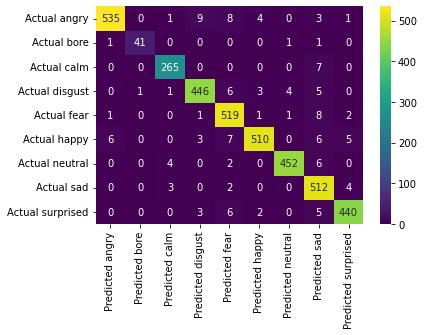

In [21]:
labels = unique_labels(y_actual)
column = [f'Predicted {label}' for label in labels]
indices = [f'Actual {label}' for label in labels]
table = pd.DataFrame(confusion_matrix(y_actual, y_pred),
                     columns=column, index=indices)
sns.heatmap(table, annot=True, fmt='d', cmap= 'viridis')

In [45]:
loaded_model = load_model('C:/Users/AdityaNandgaokar/Aimpower/Main/Emotion_Recognition/Models/CNN/model_CNN.h5')

In [68]:
feature_test = []
files = []
#test_files = []

# for test_file in glob.glob('C:/Users/AdityaNandgaokar/Aimpower/Main/Speech2Text/output/*/vocals.wav'): 
#     test_files.append(test_file)
#     audio, sample_rate = librosa.core.load(test_file, res_type='kaiser_fast')
#     feature = feature_extractor_audio_file(audio, sample_rate, mfcc = True, chroma = True, mel=True)
#     feature_test.append(feature)
    

# test_files = ['C:/Users/AdityaNandgaokar/Aimpower/Main/Speech2Text/output/15-066456-01_c2_Forgetful_30/vocals.wav',
#               'C:/Users/AdityaNandgaokar/Aimpower/Main/Speech2Text/output/TEST_Oneminuteofsilence(ID0917)_BSB/vocals.wav']

# for test_file in test_files:
ss = joblib.load('C:/Users/AdityaNandgaokar/Aimpower/Main/Emotion_Recognition/scaled_train_data.bin')
test_file = 'C:/Users/AdityaNandgaokar/Aimpower/Main/Speech2Text/output/OLAY_LADYLESHURR_20s_9x16_noSub/vocals.wav'
audio, sample_rate = librosa.core.load(test_file, res_type='kaiser_fast')
feature = feature_extractor_audio_file(audio, sample_rate, mfcc = True, chroma = True, mel=True)

feature_test.append(feature)


test_arr = np.array(feature_test)
print(test_arr.shape)
scaled_test_feature = ss.transform(feature_test)

print(scaled_test_feature)

final_feature = np.expand_dims(scaled_test_feature, -1)

pred = loaded_model.predict(final_feature)

for i in range(len(pred)):
    #print(test_files[i])
    print(i)
    #print(test_files[i])
    label = np.argmax(pred[i], axis=None, out=None)
    emotion = label_encoder.inverse_transform([label])
    
    print('Predicted Emotion is {}'. format(emotion[0]))
    
    prediction = pred[i] * 100
    print(prediction)
    prediction_dict = {}
    
    for j in range(len(prediction)):
        value = ("%.17f" % prediction[j]).rstrip('0').rstrip('.')
        key_emotion = label_encoder.inverse_transform([j])

        prediction_dict[key_emotion[0]] = value
    
    sorted_pred_dict = dict(sorted(prediction_dict.items(),
                                   key=operator.itemgetter(1),
                                   reverse=True))
    print('Confidence For All Emotions\n')
    for k in sorted_pred_dict:
        print('{} = {}'.format(k, sorted_pred_dict[k]))  
    print('\n')
    

(1, 180)
[[ 8.34684842e-01 -6.26618282e-02 -2.17765041e+00 -5.71181478e-01
  -2.98353715e+00 -1.06621462e+00  1.75596251e+00 -3.60355629e+00
  -2.46488003e+00 -1.30637883e+00 -3.84457610e+00 -7.54252969e-01
  -3.94550271e+00 -1.11392655e+00 -3.76937428e+00 -1.42449348e+00
  -1.39604193e+00 -2.96828258e+00 -1.51639696e+00 -1.18059507e+00
  -6.58226217e-01 -1.28250497e+00 -1.72468128e+00  2.24207907e-01
  -6.69369658e-01 -3.23867372e-01  6.11457806e-03  7.15746259e-01
   1.19754040e-01  6.70042158e-01  6.14932284e-01  4.25497932e-01
   4.29346021e-01  4.51012773e-01  3.01398161e-02  3.24710618e-01
  -2.89849389e-01 -1.65353160e-02 -4.96590442e-01 -5.04155768e-01
  -5.85982926e-01 -7.85364957e-01 -7.89484890e-01 -8.09908974e-01
  -1.00673875e+00 -1.28416948e+00 -1.33972187e+00 -1.02895233e+00
  -8.78401454e-01 -4.02040147e-01 -9.68596111e-02 -1.43941011e-01
  -1.69913619e-01 -1.16711173e-01 -7.70796440e-02 -9.03098253e-02
  -1.56600553e-01 -1.32779723e-01 -1.23054179e-01 -1.63794014e-02
 